In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [30]:

path = '../../../Atliq Marts Challenge'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")
dim_date=pd.read_csv(path+"/dim_date.csv")
dim_date = dim_date.rename(columns={'date': 'agreed_delivery_date','mmm_yy': 'agreed_delivery_mmm_yy','week_no': 'agreed_delivery_week_num'})





In [31]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
result =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
df =pd.merge( result ,dim_date , how="outer",on=["agreed_delivery_date"])


In [32]:
df.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%,agreed_delivery_mmm_yy,agreed_delivery_week_num
0,FMR32603203,01-Mar-22,789603.0,25891203.0,460.0,02-Mar-22,03-Mar-22,460.0,1.0,0.0,1.0,Info Stores,Vadodara,AM Butter 500,Dairy,92.0,75.0,69.0,Mar 22,W 10
1,FMR32401103,01-Mar-22,789401.0,25891103.0,476.0,02-Mar-22,02-Mar-22,476.0,1.0,1.0,1.0,Propel Mart,Surat,AM Milk 100,Dairy,85.0,79.0,67.0,Mar 22,W 10
2,FMR32320302,01-Mar-22,789320.0,25891203.0,347.0,02-Mar-22,02-Mar-22,347.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Butter 500,Dairy,91.0,81.0,74.0,Mar 22,W 10
3,FMR32320302,01-Mar-22,789320.0,25891302.0,54.0,02-Mar-22,02-Mar-22,54.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Ghee 150,Dairy,91.0,81.0,74.0,Mar 22,W 10
4,FMR32320202,01-Mar-22,789320.0,25891202.0,211.0,02-Mar-22,03-Mar-22,211.0,1.0,0.0,1.0,Chiptec Stores,Surat,AM Butter 250,Dairy,91.0,81.0,74.0,Mar 22,W 10


In [33]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
df.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [34]:
df['actual_delivery_date_formatted'] = pd.to_datetime(df['actual_delivery_date'], format='%d-%b-%y')

df = df.sort_values(by='actual_delivery_date_formatted')

In [35]:
# feature = ['customer_name','product_name','delivery_qty','in_full','on_time','on_time_in_full','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
# feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty','agreed_delivery_mmm_yy','agreed_delivery_week_num']

df = df[feature]

In [36]:
df = df.drop_duplicates()
# Check for duplicated rows
duplicated_rows = df.duplicated()

# Filter the DataFrame to show duplicated rows
duplicated_df = df[duplicated_rows]

print("Duplicated Rows:")
print(duplicated_df)

Duplicated Rows:
Empty DataFrame
Columns: [customer_name, product_name, city, category, ontime_target_percent, infull_target_percent, otif_target_percent, order_qty, agreed_delivery_mmm_yy, agreed_delivery_week_num]
Index: []


In [37]:
Obj_feature = ['customer_name','product_name','city','category']
for e in Obj_feature:
    tmp = pd.get_dummies(df[e],drop_first=True)
    df.drop([e],axis=1,inplace=True)
    df = pd.concat([df,tmp],axis=1)
df.shape

(56634, 41)

In [38]:
df[['month', 'year']] = df['agreed_delivery_mmm_yy'].str.split(' ', expand=True)
df.drop(['agreed_delivery_mmm_yy'],axis=1,inplace=True)
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace month names with numeric values
df['month'] = df['month'].replace(month_mapping)

df[['W', 'agreed_delivery_week_no']] = df['agreed_delivery_week_num'].str.split(' ', expand=True)
df.drop(['agreed_delivery_week_num'],axis=1,inplace=True)
df.drop(['W'],axis=1,inplace=True)

In [39]:

def read_data (months,df):
    i=0
    for month in months:
        if i !=0:
            features_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns =='order_qty']
            features = pd.concat([features, features_temp])
            labels = pd.concat([labels, labels_temp])
        else :
            features=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels=df[df['month']==month].loc[:, df[df['month']==month] .columns =='order_qty']
        i+=1
    return features,labels


In [40]:

x_train, y_train = read_data([3,4,5,6],df)
# use data from month 9 as validation set
x_val, y_val = read_data([7],df)

# use data from month 10 as test set
x_test, y_test = read_data([8],df)
print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (37359, 41)
y_train shape: (37359, 1) 

x_val shape: (9608, 41)
y_val shape: (9608, 1) 

x_test shape: (9367, 41)
y_test shape: (9367, 1)


In [41]:
y_train

,order_qty
77,86.0
24,397.0
6,77.0
104,208.0
87,42.0
...,...
21899,84.0
22059,397.0
21971,61.0
22066,422.0


In [42]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [43]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [44]:
x_train

,ontime_target_percent,infull_target_percent,otif_target_percent,Atlas Stores,Chiptec Stores,Coolblue,Elite Mart,Expert Mart,Expression Stores,Info Stores,...,AM Tea 100,AM Tea 250,AM Tea 500,Surat,Vadodara,Dairy,Food,month,year,agreed_delivery_week_no
77,92.0,67.0,62.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,3.0,22,10
24,78.0,77.0,60.0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,3.0,22,10
6,91.0,76.0,69.0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,3.0,22,10
104,90.0,79.0,71.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,3.0,22,10
87,85.0,80.0,68.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,3.0,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21899,78.0,77.0,60.0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,6.0,22,27
22059,85.0,81.0,69.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,6.0,22,27
21971,75.0,68.0,51.0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,6.0,22,27
22066,76.0,79.0,60.0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,6.0,22,27


In [45]:
x_train.to_numpy(dtype='float32')

array([[92., 67., 62., ...,  3., 22., 10.],
       [78., 77., 60., ...,  3., 22., 10.],
       [91., 76., 69., ...,  3., 22., 10.],
       ...,
       [75., 68., 51., ...,  6., 22., 27.],
       [76., 79., 60., ...,  6., 22., 27.],
       [85., 79., 67., ...,  6., 22., 27.]], dtype=float32)

In [46]:
normalizer = normalizer_std(x_train) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train.to_numpy(), y_train.to_numpy(), normalizer)
val_dataset = RainfallDatasetFF(x_val.to_numpy(), y_val.to_numpy(), normalizer)
test_dataset = RainfallDatasetFF(x_test.to_numpy(), y_test.to_numpy(), normalizer)

(37359, 41)
(37359, 1)
(9608, 41)
(9608, 1)
(9367, 41)
(9367, 1)


In [47]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [48]:
loss_fn = nn.L1Loss()

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(41, hidden_size)
        self.do1 = nn.Dropout(p=0.3)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.do2 = nn.Dropout(p=0.3)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.do3 = nn.Dropout(p=0.3)
        self.out = nn.Linear(hidden_size, 1)


    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        x2 = F.relu(self.do1(hd1))
        hd2 = F.relu(self.ff2(x2))
        x3 = F.relu(self.do2(hd2))
        hd3 = F.relu(self.ff3(x3))
        y = F.relu(self.do3(hd3))
        y = self.out(y)
        return y.reshape(-1, 1)

In [51]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 500,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 30
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [52]:
# from torchviz import make_dot
# # Visualize model with torchviz
# sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
# sample_y = model_ff(sample_inputs.to(device))
# make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [53]:
summary(model_ff, input_size=(64, 41))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [64, 1]                   --
├─Linear: 1-1                            [64, 500]                 21,000
├─Dropout: 1-2                           [64, 500]                 --
├─Linear: 1-3                            [64, 500]                 250,500
├─Dropout: 1-4                           [64, 500]                 --
├─Linear: 1-5                            [64, 500]                 250,500
├─Dropout: 1-6                           [64, 500]                 --
├─Linear: 1-7                            [64, 1]                   501
Total params: 522,501
Trainable params: 522,501
Non-trainable params: 0
Total mult-adds (M): 33.44
Input size (MB): 0.01
Forward/backward pass size (MB): 0.77
Params size (MB): 2.09
Estimated Total Size (MB): 2.87

In [54]:
train_losses = []
val_losses = []
learning_rates = []

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

print('Finished Training')

Training epoch 1...
Current LR: 0.01


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 1 train loss: nan
Validating epoch 1


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1 val loss: nan
Training epoch 2...
Current LR: 0.01


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 2 train loss: nan
Validating epoch 2


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2 val loss: nan
Training epoch 3...
Current LR: 0.01


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 3 train loss: nan
Validating epoch 3


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3 val loss: nan
Training epoch 4...
Current LR: 0.002


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 4 train loss: nan
Validating epoch 4


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4 val loss: nan
Training epoch 5...
Current LR: 0.002


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 5 train loss: nan
Validating epoch 5


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5 val loss: nan
Training epoch 6...
Current LR: 0.002


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 6 train loss: nan
Validating epoch 6


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6 val loss: nan
Training epoch 7...
Current LR: 0.0004


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 7 train loss: nan
Validating epoch 7


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7 val loss: nan
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 8 train loss: nan
Validating epoch 8


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8 val loss: nan
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 9 train loss: nan
Validating epoch 9


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9 val loss: nan
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 10 train loss: nan
Validating epoch 10


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10 val loss: nan
Training epoch 11...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 11 train loss: nan
Validating epoch 11


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11 val loss: nan
Training epoch 12...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 12 train loss: nan
Validating epoch 12


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12 val loss: nan
Training epoch 13...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 13 train loss: nan
Validating epoch 13


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13 val loss: nan
Training epoch 14...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 14 train loss: nan
Validating epoch 14


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14 val loss: nan
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 15 train loss: nan
Validating epoch 15


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15 val loss: nan
Training epoch 16...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 16 train loss: nan
Validating epoch 16


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16 val loss: nan
Training epoch 17...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 17 train loss: nan
Validating epoch 17


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17 val loss: nan
Training epoch 18...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 18 train loss: nan
Validating epoch 18


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18 val loss: nan
Training epoch 19...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 19 train loss: nan
Validating epoch 19


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19 val loss: nan
Training epoch 20...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 20 train loss: nan
Validating epoch 20


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20 val loss: nan
Training epoch 21...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 21 train loss: nan
Validating epoch 21


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21 val loss: nan
Training epoch 22...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 22 train loss: nan
Validating epoch 22


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22 val loss: nan
Training epoch 23...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 23 train loss: nan
Validating epoch 23


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23 val loss: nan
Training epoch 24...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 24 train loss: nan
Validating epoch 24


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24 val loss: nan
Training epoch 25...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 25 train loss: nan
Validating epoch 25


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25 val loss: nan
Training epoch 26...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 26 train loss: nan
Validating epoch 26


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26 val loss: nan
Training epoch 27...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 27 train loss: nan
Validating epoch 27


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27 val loss: nan
Training epoch 28...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 28 train loss: nan
Validating epoch 28


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28 val loss: nan
Training epoch 29...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 29 train loss: nan
Validating epoch 29


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29 val loss: nan
Training epoch 30...
Current LR: 0.0001


  0%|          | 0/584 [00:00<?, ?it/s]

Epoch 30 train loss: nan
Validating epoch 30


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30 val loss: nan
Finished Training


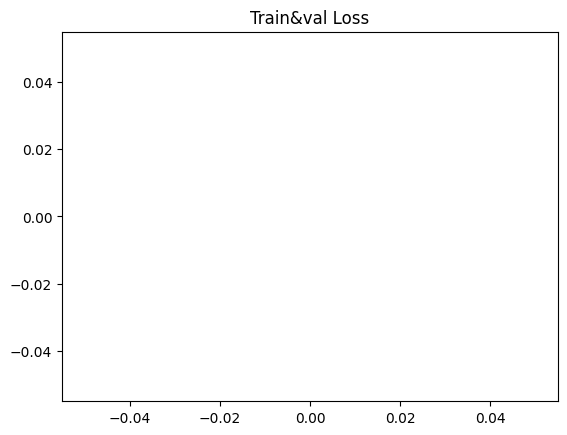

In [55]:
x = [i + 1 for i in range(config['epochs'])]

plt.plot(x, train_losses,color = 'blue')
plt.title("Train&val Loss")
plt.plot(x, val_losses,color = 'red')

plt.show()

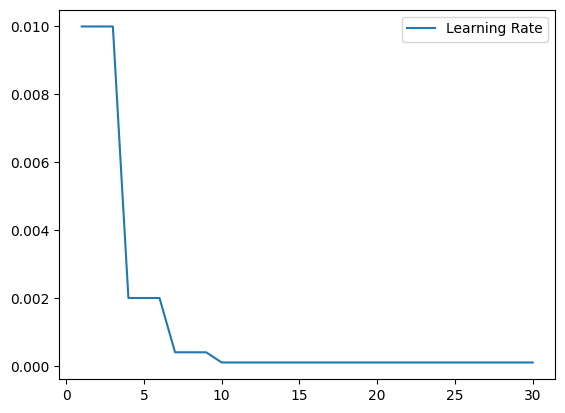

In [56]:
plt.plot(x, learning_rates, label="Learning Rate")
plt.legend()
plt.show()